In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.regularizers import L2
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import datetime as dt
import os

# setting seed for reproducibility
tf.random.set_seed(42)

In [130]:
# getting all the stocks from the files

directory = './Stocks'

l = ['Date', 'Close']
stocks= pd.DataFrame(columns=l)
for file in os.listdir(directory):
    f = os.path.join(directory, file)
    s = pd.read_csv(f)
    s = s[['Date', 'Close']]
    s['Company_name'] = file
    stocks = pd.concat([stocks, s])
    

In [131]:
from sklearn.preprocessing import MinMaxScaler

# making the dataset stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset['Close'][i] - dataset['Close'][i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


def scale_dataset(X):
    """
    A function to scale the pandas Series into tanh range (-1 and 1)
    Returns: The scaled Series and the scaler 
    """
    X = X.reshape(len(X), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)
    scaled_series = pd.Series(scaled_X[:, 0])
    return scaled_series, scaler



In [132]:
def get_train_test(dataset, company_names, train_test_ratio: float, n_days: int):
    """
    A function to split the dataset into training and test sets.
    Creates a table with the previous n_days stock prices for the same company and the current price
    
    Parameters: 
    -dataset: A pandas Series that contains the stock price for a day
    -company_names: A Pandas Series that contains the companies names to verify if it belongs to the same company
    -train_test_ratio: The ratio of train to test
    -n_days: How many days before the instance day are to be included in the table
    
    Return: training and test dataset
    """
    n_train = int(len(dataset)*train_test_ratio)
    col_names = []
    for j in range(n_days, 0, -1):
        col_names.append(f'Price_{j}_db')
    col_names.append('Price_today')
    l = []
    
    for i in range(n_days, len(dataset)):
        
        l.append([])
        # if it's not from the same company
        if company_names.iloc[i] is not company_names.iloc[i-n_days]:
            continue
        
        for j in range(n_days, 0, -1):
            l[i-n_days].append(dataset.iloc[i-j])
        l[i-n_days].append(dataset.iloc[i])

    X = pd.DataFrame(l, columns=col_names)
    # taking care of all the instances that have NaN
    X = X.dropna()
    #X = shuffle(X)
    train = X[:n_train]
    test = X[n_train:-1]
    return train, test

In [133]:
# diff_dataset = difference(stocks)
scaled_dataset, scaler = scale_dataset(stocks['Close'].to_numpy())
train, test = get_train_test(scaled_dataset, stocks['Company_name'], train_test_ratio=0.8, n_days=5)

train_y = train['Price_today']
train_X = train.drop(['Price_today'], axis=1)

test_y = test['Price_today']
test_X = train.drop(['Price_today'], axis=1)


KeyboardInterrupt: 

In [140]:
def fit_lstm(train_X, train_y, batch_size, n_epochs, n_neurons, l2_value=0):
    """
    A function to fit our model into a keras LSTM
    Parameters:
    -n_epochs: How many epochs to train the model
    -n_neurons: How many neurons to include in the network
    -dropout: The dropout rate 

    Returns: The fitted model and the model history
    """
    train_y = train_y.to_numpy()
    train_X = train_X.to_numpy()
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(n_neurons, activation='relu', input_shape=(train_X.shape[1], 1), 
                   kernel_regularizer=L2(l2=l2_value)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=False)

    return model, history

In [151]:
model, history = fit_lstm(train_X, train_y, batch_size=128, n_epochs=10, n_neurons=32, l2_value=0.1)

Epoch 1/10
1691/1691 [==============================] - 8s 4ms/step - loss: 0.0382
Epoch 2/10
1691/1691 [==============================] - 8s 5ms/step - loss: 0.0052
Epoch 3/10
1691/1691 [==============================] - 7s 4ms/step - loss: 0.0051
Epoch 4/10
1691/1691 [==============================] - 7s 4ms/step - loss: 0.0052
Epoch 5/10
1691/1691 [==============================] - 7s 4ms/step - loss: 0.0051
Epoch 6/10
1691/1691 [==============================] - 8s 5ms/step - loss: 0.0050
Epoch 7/10
1691/1691 [==============================] - 7s 4ms/step - loss: 0.0048
Epoch 8/10
1691/1691 [==============================] - 7s 4ms/step - loss: 0.0046
Epoch 9/10
1691/1691 [==============================] - 7s 4ms/step - loss: 0.0047
Epoch 10/10
1691/1691 [==============================] - 7s 4ms/step - loss: 0.0045


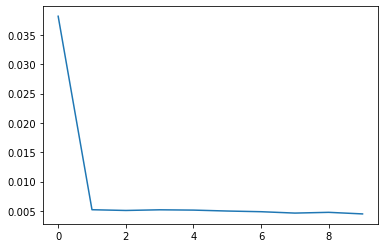

In [152]:
# Plotting the loss throughout the epochs 
plt.plot(history.history['loss'])
plt.show()

In [153]:
def predict_value(days_before, scaler, model):
    db = days_before.to_numpy()
    db = db.reshape(len(db), 1)
    scaled_db = scaler.transform(db)
    scaled_predicted_price = model.predict(np.array([scaled_db]))
    predicted_price = scaler.inverse_transform(scaled_predicted_price)
    return predicted_price

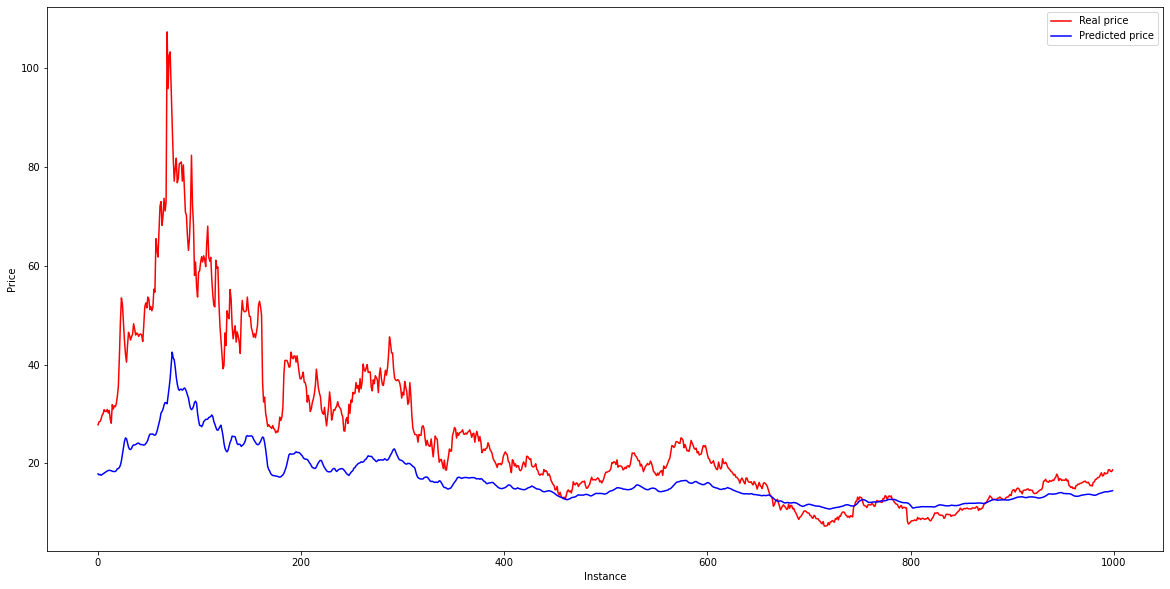

In [154]:
def plot_predicted_actual(X, y, scaler, model, n_points=1000):
    

    #plt.plot(x) 
    x = range(np.shape(X)[0])
    
    #scaled predicted price
    spp = model.predict(X)
    upp = scaler.inverse_transform(spp)
    # unscaled y
    uy = scaler.inverse_transform(y.to_numpy().reshape(-1,1))
    
    plt.figure(figsize=(20,10))
    plt.plot(x[:n_points], uy[:n_points], color='red', label='Real price')
    plt.plot(upp[:n_points], color='blue', label='Predicted price')
    plt.xlabel('Instance')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    return 

plot_predicted_actual(train_X, train_y, scaler, model)

In [155]:
stocks.iloc[20025:20030]['Close']

2925    25.59
2926    26.20
2927    26.63
2928    26.81
2929    26.61
Name: Close, dtype: float64

In [156]:
stocks.iloc[20030]['Close']

26.42

In [157]:
predict_value(stocks[20025:20030]['Close'], scaler, model)

array([[17.118631]], dtype=float32)

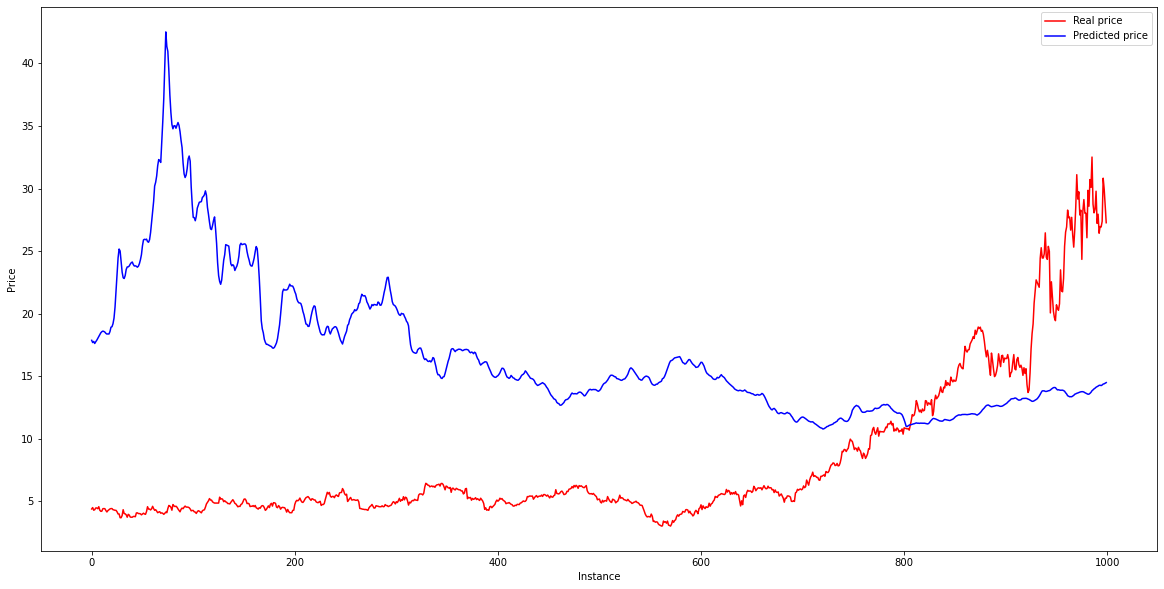

In [158]:
plot_predicted_actual(test_X, test_y, scaler, model)